# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
from scipy.fft import fft, fftfreq

import time

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [2]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
#we only take the seconds 3-6
lfp = lfp[3000:6000]
sampling_rate = lfp_data['sampling_rate']

In [3]:
n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum

centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

Take a few seconds of the data, and filter them in different frequency bands. 
Plot the resulting singal. Fix the central frequency and play with the width of the band

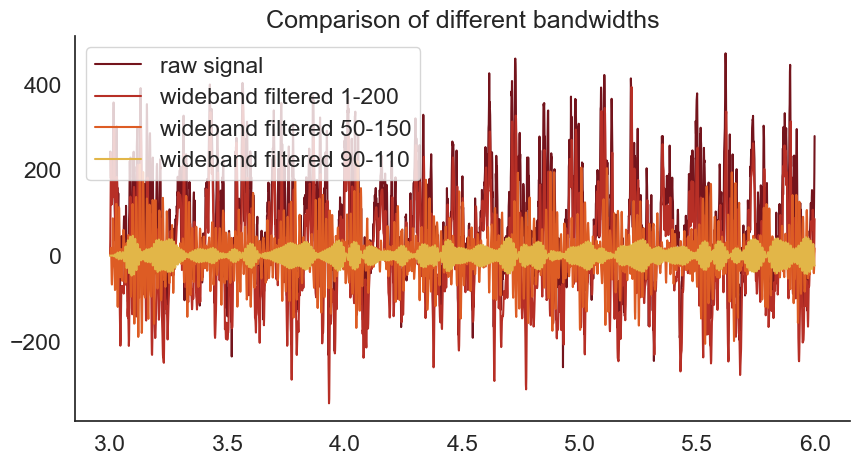

In [4]:
from scipy.signal import butter
from scipy.signal import sosfilt


#low_f = 1
#high_f = 200

bands = np.array(([1,200],[50,150],[90,110]))

colors = ['#74141C','#B72F26','#DD5C24','#E2B648']

def bandwidth(band,order,title):
    filter_order = order #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability

    
    plt.figure(figsize=(10,5))
    plt.plot(np.linspace(3,6,3000),lfp,color = colors[0],label='raw signal')
    
    for i in range(band.shape[0]):
        #define filter object
        low_f  = band[i][0]
        high_f = band[i][1]
        filter = butter(filter_order,[low_f,high_f],
                        btype='band', 
                        output='sos', 
                        fs=sampling_rate)
                        
        #apply filter to lfp       
        wideband_lfp = sosfilt(filter, lfp)
    
        plt.plot(np.linspace(3,6,3000),wideband_lfp,color = colors[i+1],label = 'wideband filtered '+str(low_f)+'-'+str(high_f))
    
    plt.title(title)
    plt.legend()

bandwidth(bands,5,"Comparison of different bandwidths")

We observe a decreasing amplitude coming with a smaller bandwidth. With that comes a more smooth signal at a smaller bandwidth.

Change the central frequency of the band

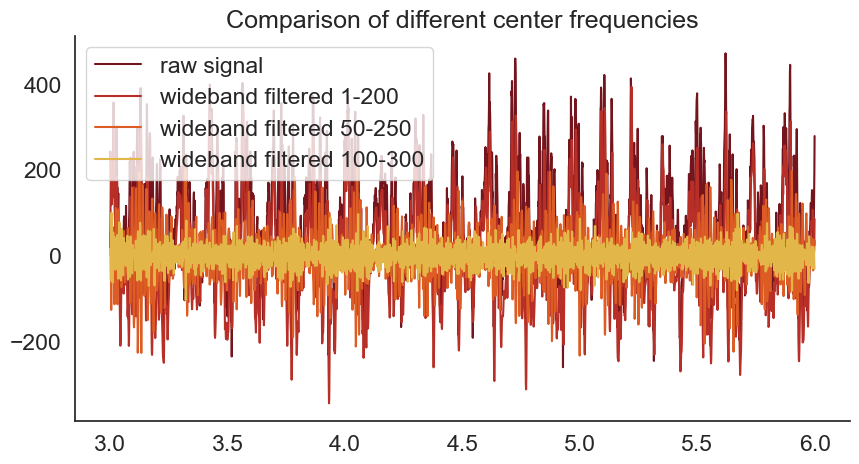

In [5]:
bands = np.array(([1,200],[50,250],[100,300]))

bandwidth(bands,5,"Comparison of different center frequencies")

We also observe a decrease of amplitude here but end up with a just as noisy signal at higher frequencies.

Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change?

Runtime of the program for filter order 2 is 0.004971981048583984 seconds
Runtime of the program for filter order 3 is 0.0036580562591552734 seconds
Runtime of the program for filter order 4 is 0.0033130645751953125 seconds
Runtime of the program for filter order 5 is 0.0033860206604003906 seconds
Runtime of the program for filter order 6 is 0.003721952438354492 seconds
Runtime of the program for filter order 7 is 0.003489971160888672 seconds


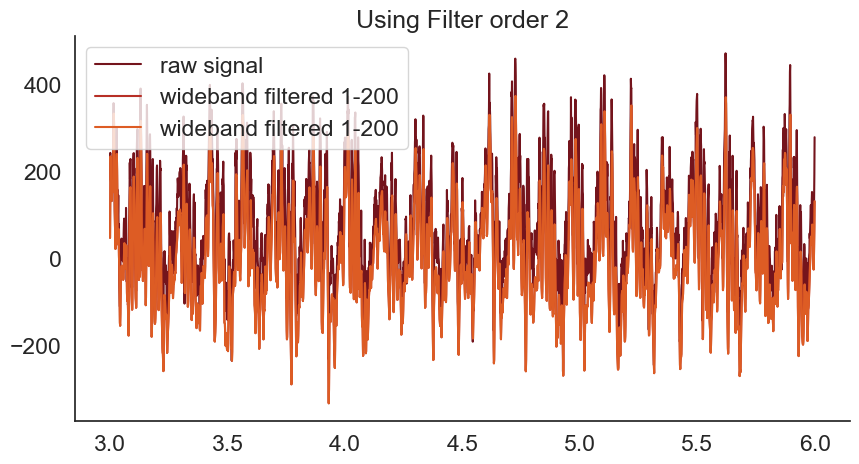

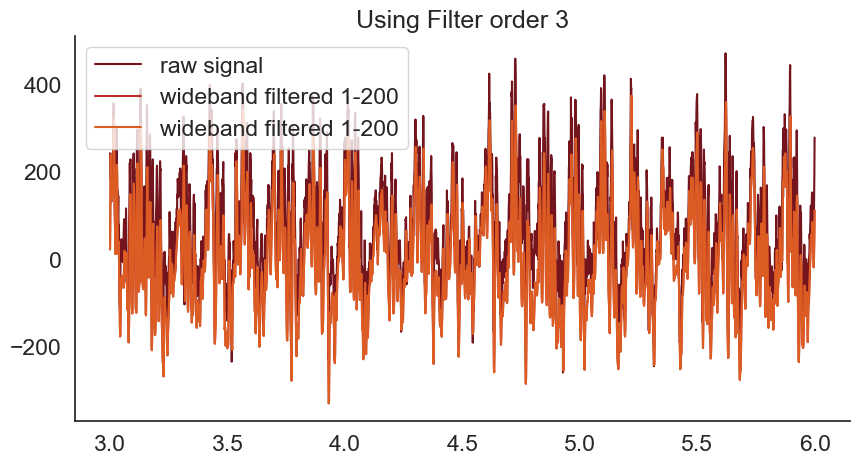

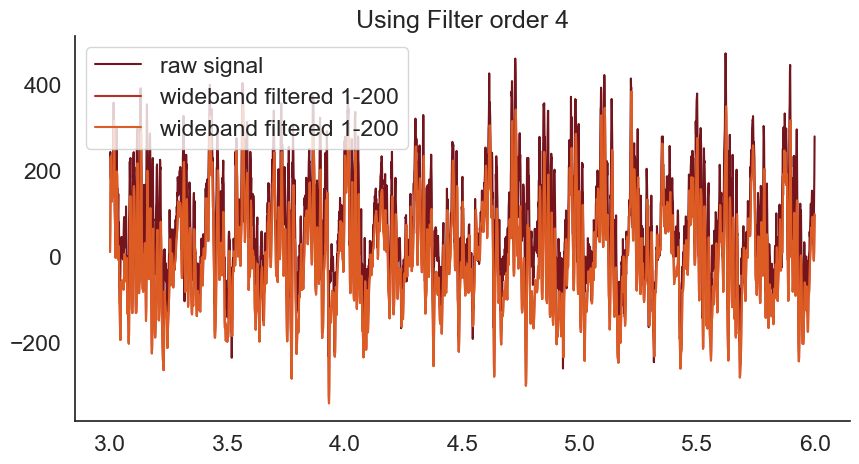

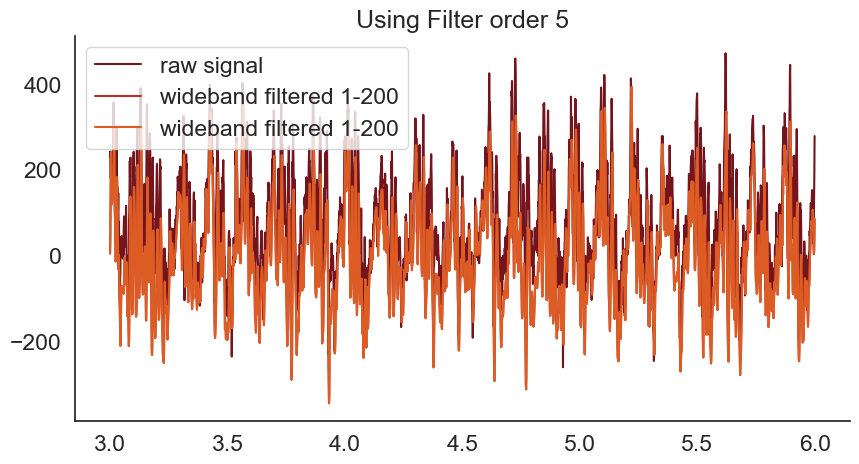

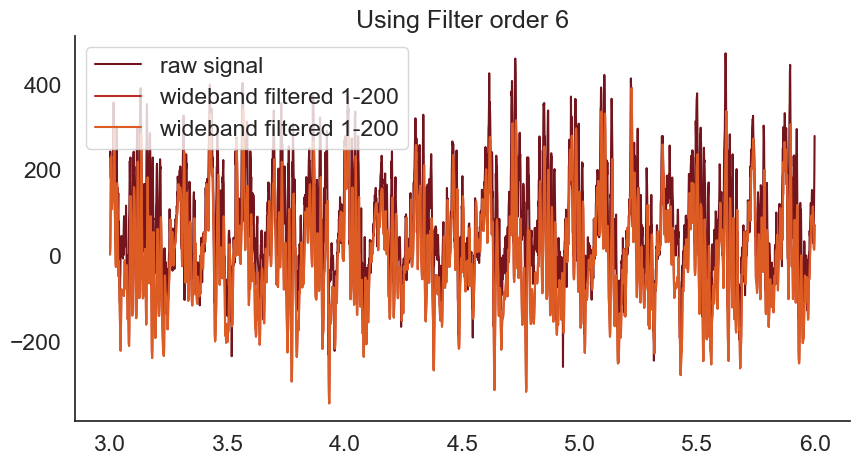

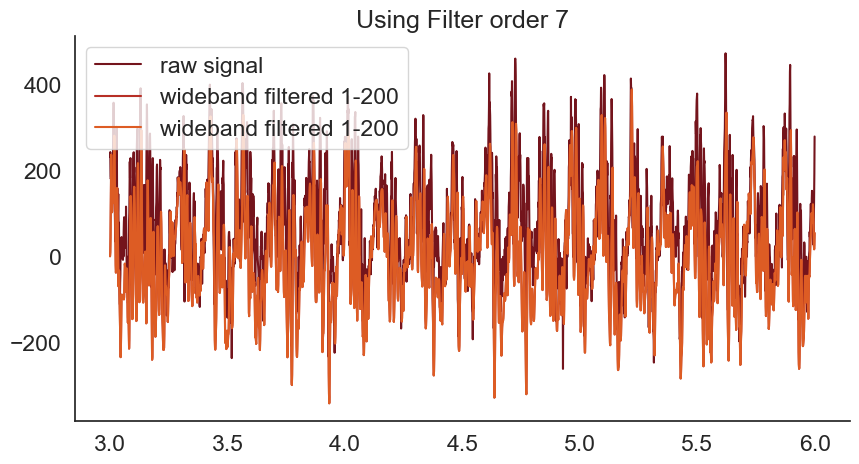

In [6]:
bands = np.array(([1,200],[1,200]))

for i in range(2,8):
    start_time = time.time()
    bandwidth(bands,i,"Using Filter order "+str(i))
    end_time = time.time()

    total_runtime = end_time - start_time
    print(f"Runtime of the program for filter order "+str(i)+f" is {total_runtime} seconds")


We observe a faster computation for higher filter orders. From what I see, the amplitude is slightly larger for higher order.

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

Try the wavelet transform with wavelet mexh (mexican hat),gaus (gaussian) and morl (morlet).

In [12]:
from scipy import signal
import pywt
from pywt import scale2frequency
from pywt import cwt
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from pywt import wavelist

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
#we only take the seconds 3-6
lfp = lfp[3000:6000]
sampling_rate = lfp_data['sampling_rate']

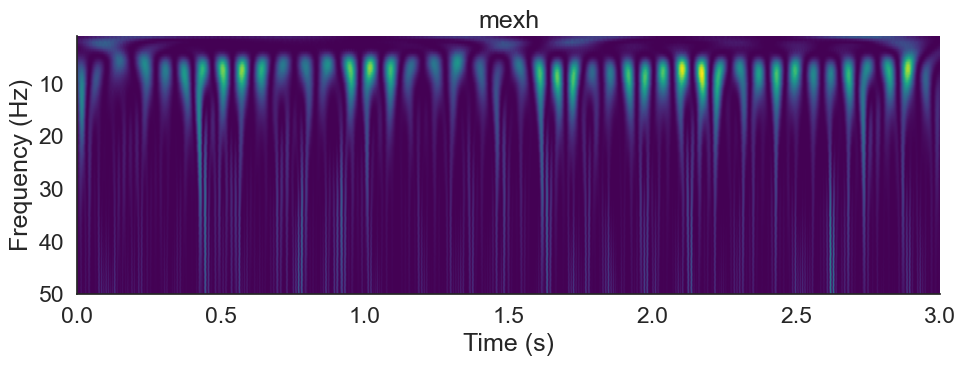

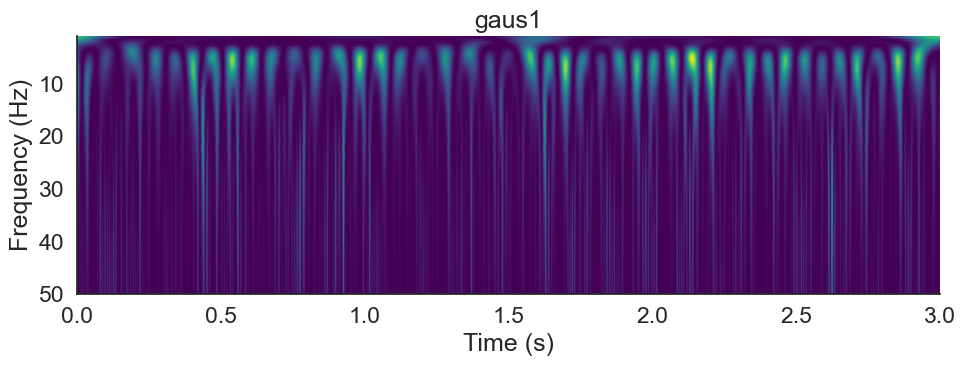

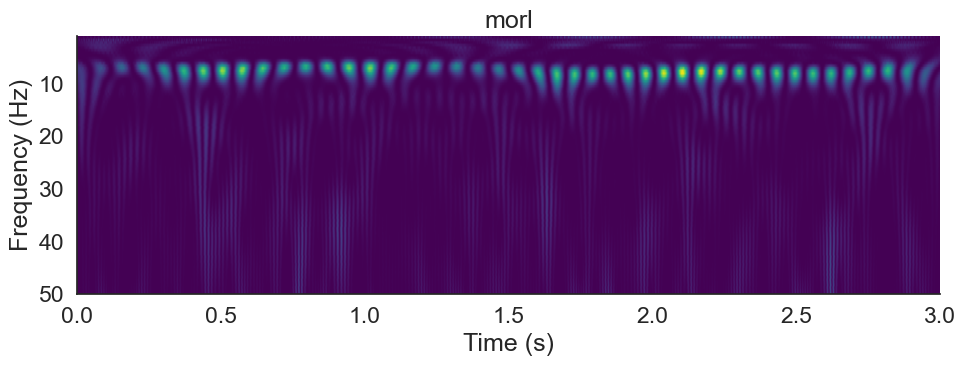

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
import pickle

def compute_and_plot_wavelet(sig, sampling_rate, wavelet_name, freq_range=(1, 50), num_freqs=100):
    frequencies = np.linspace(freq_range[0], freq_range[1], num_freqs)
    central_freq = pywt.central_frequency(wavelet_name)
    scales = central_freq * sampling_rate / frequencies

    cwtmatr, _ = pywt.cwt(sig, scales, wavelet_name, sampling_period=1.0 / sampling_rate)

    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(cwtmatr)**2, extent=[0, len(sig) / sampling_rate, frequencies[-1], frequencies[0]],
               aspect='auto', cmap='viridis')
    plt.title(f'{wavelet_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    #plt.colorbar(label='Power')
    plt.tight_layout()
    plt.show()


# Apply the function for each wavelet
for wavelet in ['mexh', 'gaus1', 'morl']:
    compute_and_plot_wavelet(lfp, sampling_rate, wavelet)

Overall the different wavelets look similar. A key difference seems to be that for higher frequencies the morl has less power. For all wavelets there seems to be a altering strength connected to the signal.

What differences do you see with respect to the spectrum computed with the complex Morlet tranform

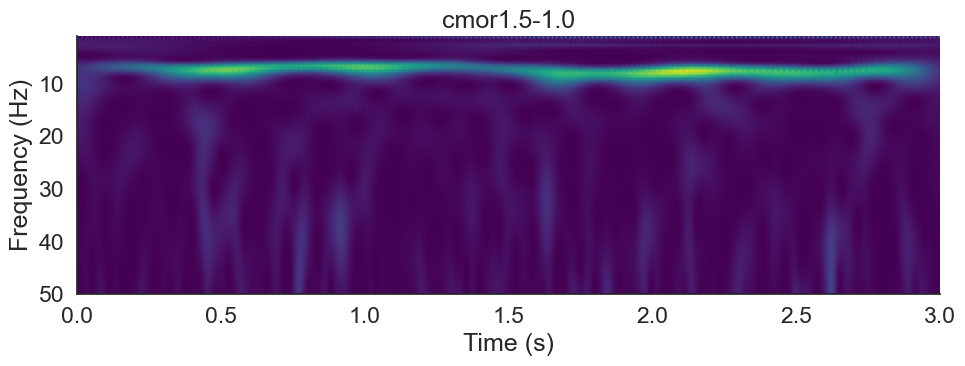

In [32]:
#bandwidth=1.5, center frequency=1.0
wavelet = 'cmor1.5-1.0'
compute_and_plot_wavelet(lfp, sampling_rate, wavelet)

#I'm not sure if the complex wavelet is used correctly like this because now the center frequency 
#and bandwidth differes from the one I use in the function


Here we don't observe the discrete form but a continuous band.

The complex Morlet transform produces a more localized spectrum in frequency compared to the three non-complex wavelets. This could be due to the fact that both phase and amplitude are included. 

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/sleep_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.